# 数字認識タスク
Notebook の利用が初めての場合 - ようこそ！Notebook はコードの近くに結果が表示されるのを見ながら実行できる素晴らしいツールです。
1. セルを実行するには、セルをクリックして SHIFT-Enter を押します。
2. 何かが実行されると、変数はメモリに保存されます - それらを調べてください。

# 訳注 Jupyter Notebook の使い方:
このワークショップでは、Azure Notebooks Service によってホストされている Jupyter ノートブックを使用します。あなたが Jupyter に精通しているならば、このセルを飛ばしてください。そうでない場合は、ここでいくつかのヒントがあります。

* Python 3.6 のカーネルを選択してください。  
* Jupyter には「セル」があります。ノートブックのどこかをクリックすると、ポインタを含むセルが選択されます。  
* セル内のコードを実行または実行するには、トップメニューで [セル]-[セルの実行] を選択します。または、Shift + Enterキーを使用することもできます。  
* セルを編集するには - セルをダブルクリックします。  
* セルを実行すると、セルの左側の外側にあるポインタが [ ] から [ \* ] に変わります。セルの実行が終了すると、[ \* ] が数字に変わります。  
* ノートブックまたはセルがハング(フリーズ)した場合は、トップメニューからノートブック全体の [Kernel]-[Restart Kernel and Clear All Outputs] を選択するか、そのセルだけを選択して [Kernel]-[Interrupt kernel] を選択します。再起動には数秒かかり、その後ですべてのセルを再実行する必要があります。  

Jupyterでは、順番に実行する必要はありません。すでに実行された前のセルに戻って再度実行することができます。特定のセルのコードが、前後のセルと依存関係を持たない限り、問題ありません。

## 始めましょう
最初のセルは必要なライブラリをインポートします。ここから始めましょう。

In [1]:
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.onnx as onnx
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## データ!
データがなければ、機械学習では何もできません。今回は「**28x28のベクトルで数字を予測できるか？**」という課題を与えられています。
  
用意できたら、データを見てみる必要があります。次のセルは数字を視覚化するヘルパー関数です（健全性チェック）。

In [2]:
def draw_digits(digits):
    fig, axes = plt.subplots(6, 20, figsize=(18, 7),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        X, y = digits[i]
        ax.imshow(255 - X.reshape(28,28) * 255, cmap='gray')
        ax.set_title('{:.0f}'.format(torch.argmax(y).item()))

次のセルは、標準的な数値データセット（MNISTと呼ばれる）をダウンロードします。この呼び出しの transform 部分と target_transform 部分は、これから行うモデルにより適したデータにするための変換手順がいくつか入っています。

In [4]:
digits = datasets.MNIST('data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.reshape(28*28))
                        ]),
                        target_transform=transforms.Compose([
                            transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, y, 1))
                        ])
                     )

ここでデータの健全性をチェックします。

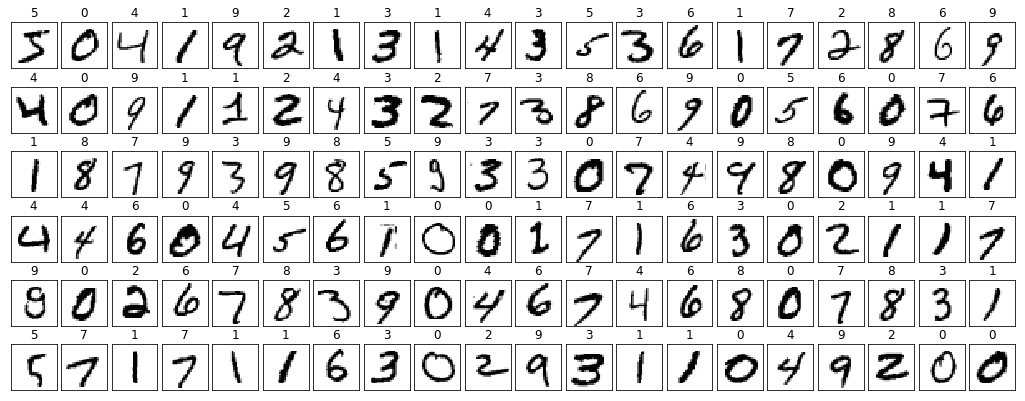

In [5]:
draw_digits(digits)

xやyを表示して、ざっとデータを見てください。これらは本当に単なる数字です！それらを見てみるといくつか奇妙に思えるかもしれません：

1.「画像は 0～255 の 784個のベクトルではないのですか？」と思いましたか。データは見た通りです！新しい範囲が 0～1 になるように255で割ってベクトルを正規化しただけです（数値がより正確になるようにしました）  
2.「y が数値の答えだったのではないですか？代わりに 10次元のベクトルになっています」と思いましたか。その通りです！これは答えの One-Hot 表現と呼ばれます。正解のインデクスの位置に "1" が入っています。繰り返しになりますが、これにより、これから作成するモデルで数値演算がよりよく機能するようになります。

In [6]:
x, y = digits[0]
print(x)
print(y)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

# モデルを選択する
いくつかのデータが得られたので、今度はうまくいくと思われるモデルの選択を開始します。これがデータサイエンスの科学的な部分が出てくるところです：私たちは推測し、それから仮定が正しいかどうかチェックします。 784個の蛇口から10本の異なるホースに水を分配する必要がある水道管のようなモデルを想像してみてください。これらの784個の蛇口は数字の個々のピクセルを表し、最後の10個のホースは実際の数（または少なくとも水が最も多く出ているもののインデックス）を表します。私たちの仕事は今その間の配管を選ぶことです。

次の3つのセルは、順に難しくなる 3つの別の構造を表しています。

1. 最初のモデルは単純な線形モデルです
2. 2番目のモデルは3層ニューラルネットワークです
3. 最後のモデルは全てが畳み込み層で構成されるニューラルネットワークです

それらがどのように働くかを完全に説明することはこのチュートリアルの範囲外ですが、正しいインデックスから最も多くの水を押し出せるように、最後に正しい水圧を生み出すように調整されなければならない内部ノブで配管していると想像してください 。下のセルほど、配管とそれに対応する内部ノブがより複雑になります。

In [7]:
class SimpleLinear(nn.Module):
    def __init__(self):
        super(SimpleLinear, self).__init__()
        self.layer1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.layer1(x)
        return F.softmax(x, dim=1)

In [8]:
class NeuralNework(nn.Module):
    def __init__(self):
        super(NeuralNework, self).__init__()
        self.layer1 = nn.Linear(28*28, 512)
        self.layer2 = nn.Linear(512, 512)
        self.output = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output(x)
        return F.softmax(x, dim=1)

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# モデルパラメータの最適化
いくつかのモデルができたので、数字を認識するのに良い仕事ができるかどうか確認するために内部パラメータを最適化する時が来ました！訓練する方法を調整するために最適化アルゴリズムを与える際に使用する、いくつかのパラメータです - これらはハイパーパラメータと呼ばれます。次に示す2つの変数です。

In [10]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

'learning_rate' は基本的に、アルゴリズムがモデルパラメータを学習する速度を指定します。あなたが「それを5000万に設定するのはどうかな？」と考えたとします。それが悪い考えである理由の最も良い例えはゴルフです。私はゴルフがうまくないので、本当によくわかりませんが、ショットを沈めようとしているのに毎回同じ距離ボールを打つようなものです。簡単ですね？今いる場所から穴までの正確な距離を打てばいいのです！それで完了です！さて、あなたは穴がどこにあるのかわからないが、おおざっぱな方向は知っているとします。あなたが選ぶ距離は実際に重要です。距離が長すぎると穴を逃すことになり、それを叩くと再び行きすぎます。距離が短すぎると、穴にたどり着くまでに時間がかかりますが、最終的には穴に到達するはずです。基本的には、1ショットあたりの正しい距離を推測してから試してみる必要があります。それが、穴に入れるための正しいパラメーターを見つけられるように、基本的に学習率がすることです。（さて、ゴルフの話は終わりです）


以下は、完全に動作するのに必要な 3つのものです:
1. **モデル** - 私たちが作ろうとしている関数であり、正解の数値を返すべきものです
2. **コスト関数** (損失関数と呼ばれることもあります) - ゴルフの話は終わったと約束したことを覚えていますが、嘘をつきました。おかしなゴルフゲームであなたが穴の大体の方向を知っていると言ったのを覚えていますか？ コスト関数は穴までの距離を教えてくれます。ゼロになると穴に入ったことになるのです！実際の科学的な用語では、コスト関数は、モデルが正しい答えを得るのにどれほど悪いかを示すものです。ゴルフショットと同じように、コスト関数が減少するのも見るべきです。減少しなければ、何か間違っています。そうならば、ショットの距離（または学習率）をもっと小さい値に変更して、もう一度試してみます。それでもうまくいかない場合は、モデルを変更してください。
3. **オプティマイザー** - この部分は、実際にモデルパラメーターを変更する部分です。それは我々がボールを打つべき方向の意味を持ち、正しい数字を予測する最良の内部の蛇口を見つけるために、モデル内部のすべての値を更新します。ここでは、バイナリークロスエントロピーコスト関数を使用します。これがうまく機能することがわかっているからです。さまざまなシナリオに合わせて、さまざまなコスト関数を選択できます。

In [11]:
# 実行する場所
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

# モデルの選択
model = SimpleLinear().to(device)
#model = NeuralNework().to(device)
#model = CNN().to(device)
print(model)

# 最良のパラメーターを決定するのに使用するコスト関数
cost = torch.nn.BCELoss()

# 最適なパラメーターを作成するために使用
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using cpu device
SimpleLinear(
  (layer1): Linear(in_features=784, out_features=10, bias=True)
)


'CUDA' について言及するのをすっかり忘れていました。基本的に for ループの中はすべての大きな行列の乗算問題であるため、GPUはこのプロセス全体をスピードアップします。PyTorchは基本的にどこで実行するか（CPU または CUDA - CUDA は計算を GPU に移行するためのプラットフォームです）をモデルに伝えるだけでいいのです。素晴らしい。

それでは、学習に進みます！データローダーの仕事は、データセット全体（ここでは 60,000個の例とそれに対応するラベル）を反復処理することですが、処理するデータを batch_sizeの サイズごとに取得します。batch_size は選択する必要があるもう1つのハイパーパラメータです。'epoch' は、データセット全体をループする回数です（これもまた、実験の進行状況に基づいて選択したものです）。

次のセルの実行には時間がかかります。

In [12]:
# loader
dataloader = DataLoader(digits, batch_size=batch_size, num_workers=0, pin_memory=True)

# golfing time!
for t in range(epochs):
    print('Epoch {}'.format(t))
    print('-------------------------------')
    # go through the entire dataset once
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        # zero out gradient
        optimizer.zero_grad()
        # make a prediction on this batch!
        pred = model(X)
        # how bad is it?
        loss = cost(pred, Y)
        # compute gradients
        loss.backward()
        # update parameters
        optimizer.step()
        
        if batch % 100 == 0:
            print('loss: {:>10f}  [{:>5d}/{:>5d}]'.format(loss.item(), batch * len(X), len(dataloader.dataset)))
            
    print('loss: {:>10f}  [{:>5d}/{:>5d}]\n'.format(loss.item(), len(dataloader.dataset), len(dataloader.dataset)))
    
print('Done!')

Epoch 0
-------------------------------
loss:   0.327997  [    0/60000]
loss:   0.117502  [ 6400/60000]
loss:   0.095166  [12800/60000]
loss:   0.082182  [19200/60000]
loss:   0.064765  [25600/60000]
loss:   0.073638  [32000/60000]
loss:   0.050911  [38400/60000]
loss:   0.082337  [44800/60000]
loss:   0.066851  [51200/60000]
loss:   0.073611  [57600/60000]
loss:   0.028481  [60000/60000]

Epoch 1
-------------------------------
loss:   0.052711  [    0/60000]
loss:   0.051933  [ 6400/60000]
loss:   0.046167  [12800/60000]
loss:   0.063981  [19200/60000]
loss:   0.041912  [25600/60000]
loss:   0.065289  [32000/60000]
loss:   0.036312  [38400/60000]
loss:   0.073197  [44800/60000]
loss:   0.056139  [51200/60000]
loss:   0.073723  [57600/60000]
loss:   0.020512  [60000/60000]

Epoch 2
-------------------------------
loss:   0.039570  [    0/60000]
loss:   0.047737  [ 6400/60000]
loss:   0.037469  [12800/60000]
loss:   0.057078  [19200/60000]
loss:   0.038286  [25600/60000]
loss:   0.0625

さて、ここでは実際には何をしたのでしょうか。素晴らしい質問です。最初の実行した SimpleLinear モデルから説明します。基本的に1つの行列と1つのベクトルを学習しています。それだけです。実際にはこういうことです:

\begin{align}
prediction = W \cdot x + b
\end{align}

\begin{align}
\begin{bmatrix}
\hat{y}_1 \\ \vdots \\ \hat{y}_{10}
\end{bmatrix}_{10 \times 1} = 
\begin{bmatrix}
w_{1,1} &  \ldots &  w_{1,784} \\
\vdots    & \ddots &  \\
w_{10,1}  & \ldots & w_{10, 784} \\
\end{bmatrix}_{10 \times 784} 
\cdot
\begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_{783} \\ x_{784}\end{bmatrix}_{784 \times 1}
 + 
\begin{bmatrix}
b_1 \\ \vdots \\ b_{10}
\end{bmatrix}_{10 \times 1}
\end{align}


行列 W とベクトル b は、SimpleLinear モデルが学習するものです。出力は 10×1 行列で、最大値を持っているものが予測したい数値のインデックスです。アルゴリズムが 2つの変数（およびサイズ）について学習した内容を見てみましょう:

In [13]:
for p in model.parameters():
    print(p.shape)
    print(p)

torch.Size([10, 784])
Parameter containing:
tensor([[ 0.0062,  0.0153,  0.0184,  ..., -0.0116,  0.0088, -0.0087],
        [-0.0174,  0.0058,  0.0123,  ..., -0.0268, -0.0128,  0.0324],
        [ 0.0220, -0.0080, -0.0083,  ..., -0.0000, -0.0168,  0.0139],
        ...,
        [ 0.0100,  0.0282, -0.0219,  ..., -0.0071, -0.0025, -0.0157],
        [-0.0154,  0.0260,  0.0105,  ..., -0.0116, -0.0063,  0.0103],
        [-0.0010,  0.0121, -0.0262,  ...,  0.0111,  0.0119, -0.0262]],
       requires_grad=True)
torch.Size([10])
Parameter containing:
tensor([-0.2752,  0.3982,  0.0538, -0.2269,  0.1070,  0.6785, -0.0616,  0.3549,
        -0.7796, -0.1151], requires_grad=True)


# 動作しているか？
正常に機能しているかどうかを判断する最良の方法は、学習プロセスで使用されていないデータでモデルをテストすることです。幸いなことに、そのようなデータセットがあります（これは既に使用したデータとは分けておいたものです）。以前と同じ方法でそれをすべてロードし、前のデータとは異なることを示すために表示してみます。

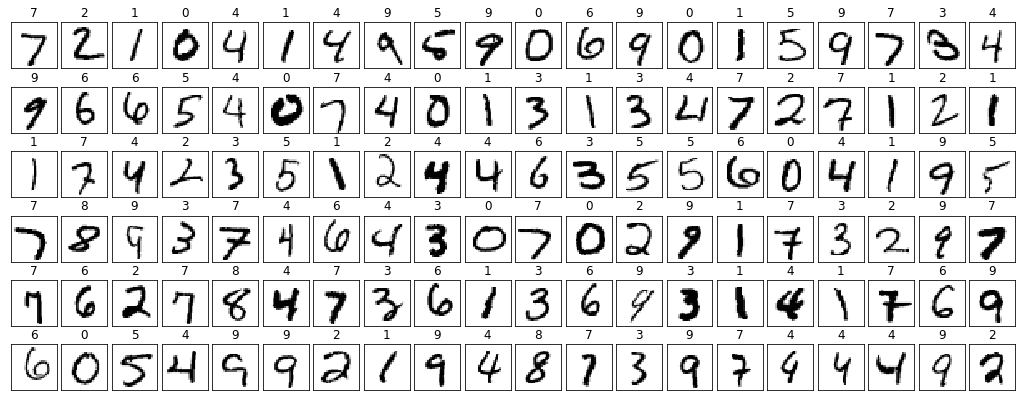

In [14]:
test_digits = datasets.MNIST('data', train=False, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.reshape(28*28))
                        ]),
                        target_transform=transforms.Compose([
                            transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, y, 1))
                        ])
                     )
draw_digits(test_digits)

最初の数値でテストしましょう（7 です）。

In [15]:
x, y = test_digits[0]
x = x.to(device).view(1, 28*28)

評価に使用するモデル（推論とも呼ばれます）を指定して、これまでに使ったことのない数値を渡します。

In [16]:
model.eval()
with torch.no_grad():
    pred = model(x)
    pred = pred.to('cpu').detach()[0]
    
print(pred)

tensor([8.6886e-06, 1.3510e-10, 1.3847e-05, 1.6423e-03, 4.5304e-07, 1.5702e-05,
        2.6928e-09, 9.9798e-01, 1.6462e-05, 3.1789e-04])


予測された数字が実際の数字と一致するかどうか見てみましょう:

In [17]:
pred.argmax(0), y.argmax(0)

(tensor(7), tensor(7))

**すべて** のテストデータに対してどれだけうまくいっているか見てみましょう！

In [18]:
# 推論用の数値のデータローダー
test_dataloader = DataLoader(test_digits, batch_size=64, num_workers=0, pin_memory=True)

# モデルを評価モードに設定
model.eval()
test_loss = 0
correct = 0

# ループ
with torch.no_grad():
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)

        test_loss += cost(pred, Y).item()
        correct += (pred.argmax(1) == Y.argmax(1)).type(torch.float).sum().item()

test_loss /= len(dataloader.dataset)
correct /= len(dataloader.dataset)
print('\nTest Error:')
print('acc: {:>0.1f}%, avg loss: {:>8f}'.format(100*correct, test_loss))


Test Error:
acc: 92.6%, avg loss: 0.000701


# モデルの保存
今回は PyTorch を使っていますが、すべてのフレームワークは異なります。モデルを (PyTorch の）内部フォーマットと ONNXフォーマットの両方で保存します（これらは大きな行列Wとベクトルbであることを覚えています）。モデルは数字を認識する必要があるたびに、実行されるプログラムにアセットとしてロードすることができます。

In [19]:
# グラフ全体を通すためのダミーの変数を作成
x = torch.randint(255, (1, 28*28), dtype=torch.float).to(device) / 255
onnx.export(model, x, 'model.onnx')
print('Saved onnx model to model.onnx')

# PyTorch モデルを保存
torch.save(model.state_dict(), 'model.pth')
print('Saved PyTorch Model to model.pth')

Saved onnx model to model.onnx
Saved PyTorch Model to model.pth


# 試してみましょう！
これでプロセス全体が完了したので、上に戻って試してみてください。次のように変更してみましょう:
1. 他のモデル（SimpleLinear を NeuralNetwork, CNN）を選択。他のモデルは、画像が最終的な答えを得るために通過する追加の行列（Wとb）を学習することを除けば、呼び出し方はほとんど同じです。
2. learning_rate、batch_size、epochなどのハイパーパラメーター。 変更で結果が良くなったり悪くなったりしますか？ 92％は問題ないですが、他のモデルとハイパーパラメータの組み合わせのほうがいいでしょうか。

## 最後に
フィードバックを歓迎します！これは役に立ちましたか？ 分かりにくい部分はありますか？簡単にでもいいので教えてください。